Домашнее задание
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import catboost as catb

In [32]:
df = pd.read_csv('weatherAUS.csv', sep=',')
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


In [33]:
df.shape

(145460, 23)

In [34]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [35]:
# Посомтрим на пропуски

df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [36]:
# Посмотрим на типы данных в датасете

df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [37]:
target_name = 'RainTomorrow'
base_feature_names = df.columns.drop([target_name]).tolist()
cat_feature_names = df.select_dtypes(include='object').columns.drop([target_name]).tolist()
num_feature_names = df.columns.drop([target_name] + cat_feature_names).tolist()

In [38]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [66]:
df.loc[df['RainTomorrow'] == 'No', 'RainTomorrow'] = 0
df.loc[df['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1

In [67]:
df['RainTomorrow'].unique()

array([0, 1, nan], dtype=object)

In [69]:
df['RainTomorrow'].isna().sum()

3267

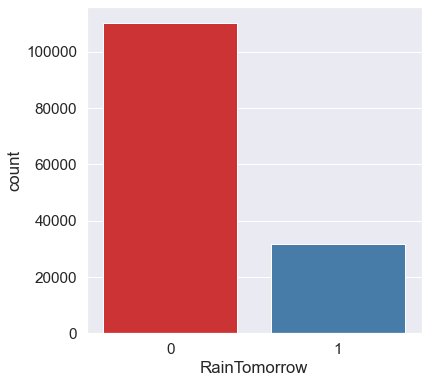

In [68]:
#Посмотрим на соотношение классов 
f, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x="RainTomorrow", data=df, palette="Set1")
plt.show()

In [40]:
#Посмотрим на соотношение классов в численном выражении
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

### Корреляция целевой переменной с базовыми признаками

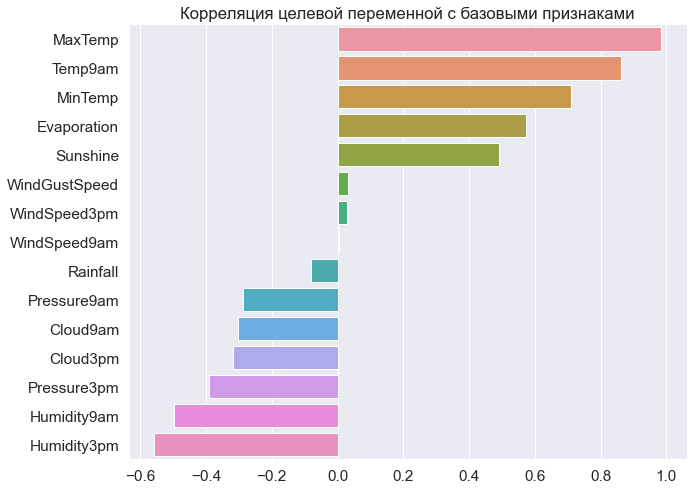

In [41]:
corr_with_target = df[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция целевой переменной с базовыми признаками')
plt.show()

### Матрица корреляций признаков

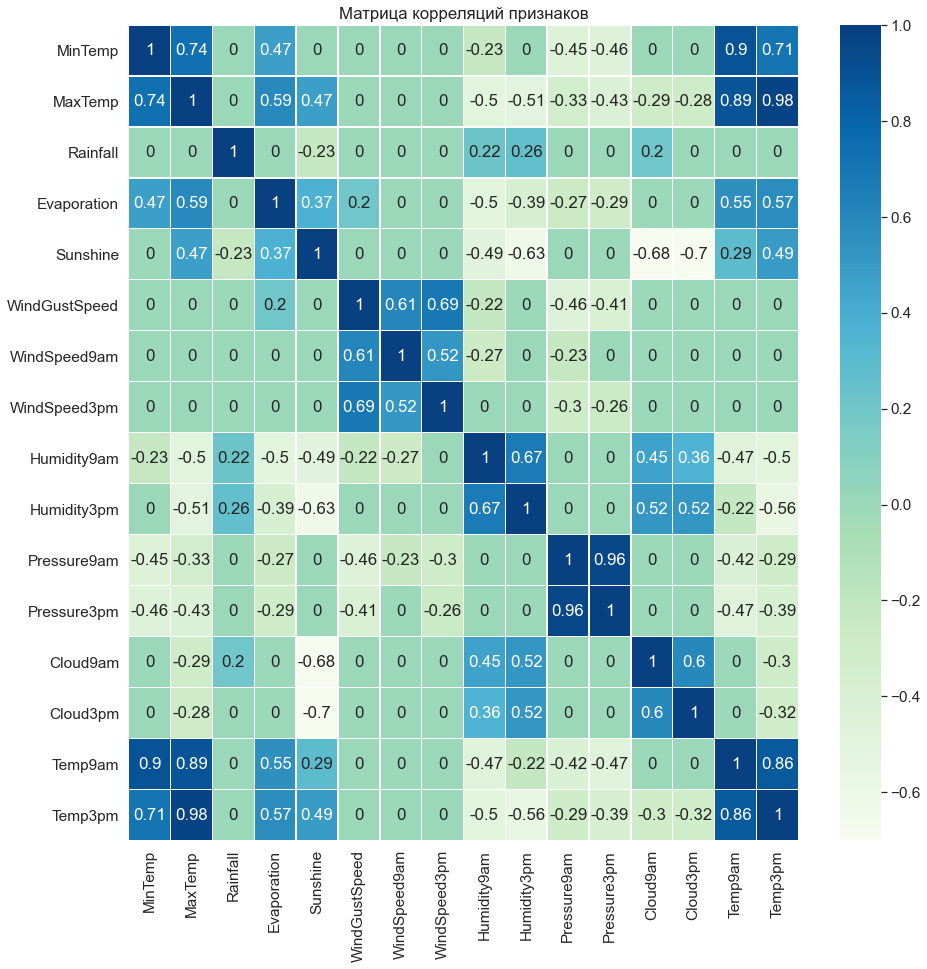

In [42]:
plt.figure(figsize = (15,15))

sns.set(font_scale=1.4)

corr_matrix = df[base_feature_names].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций признаков')
plt.show()

### Анализ выбросов

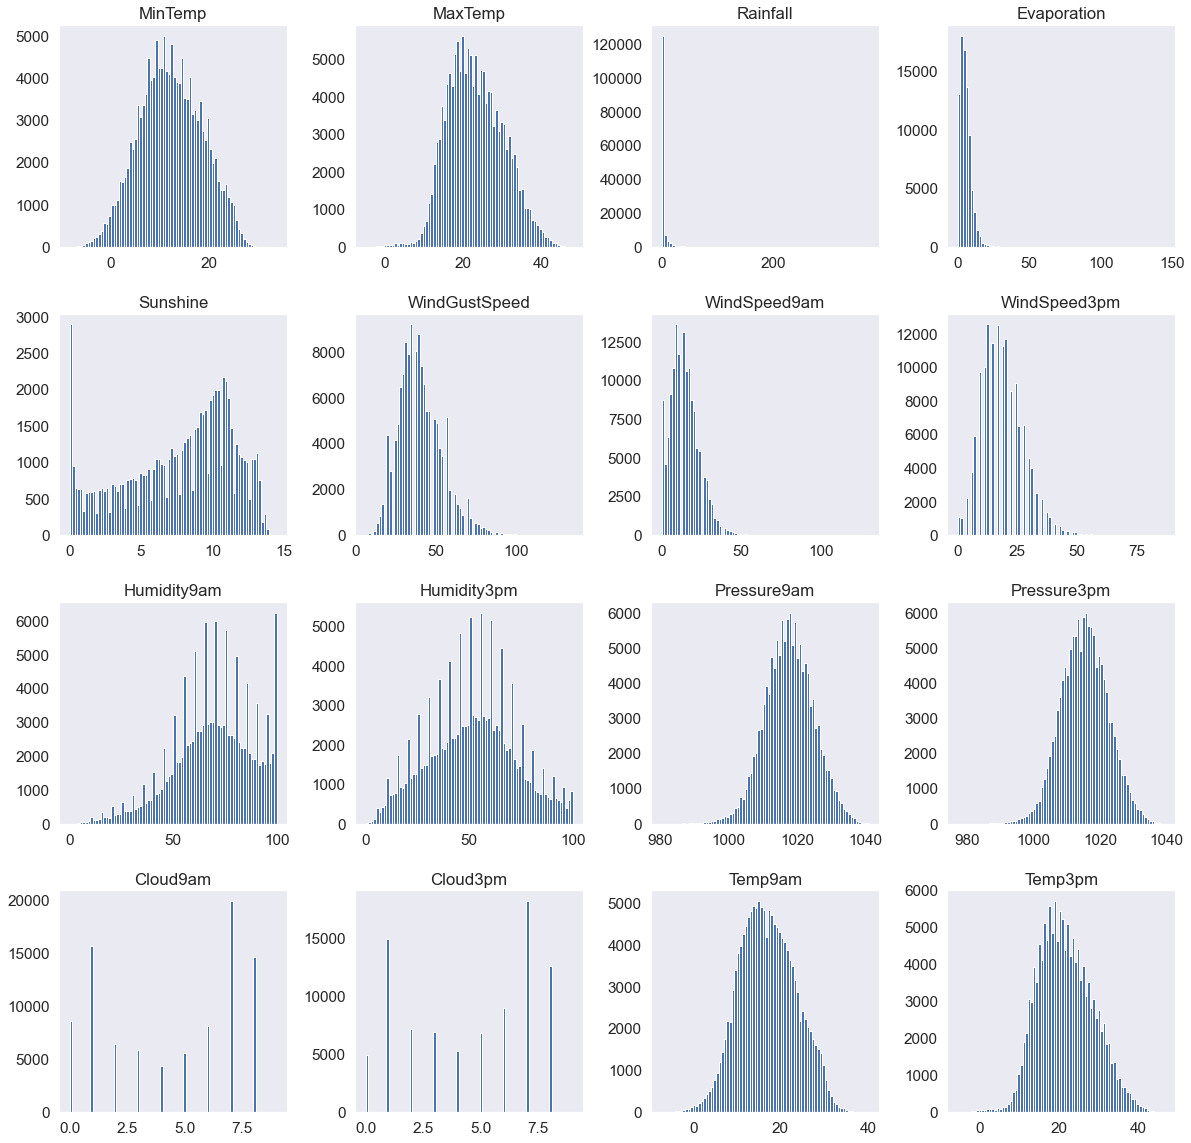

In [43]:
df[num_feature_names].hist(figsize=(20, 20), bins=80, grid=False);

In [44]:
# посомтрим на сводную статистику в числовыхпеременных

print(round(df[num_feature_names].describe()),2)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  143975.0  144199.0  142199.0      82670.0   75625.0       135197.0   
mean       12.0      23.0       2.0          5.0       8.0           40.0   
std         6.0       7.0       8.0          4.0       4.0           14.0   
min        -8.0      -5.0       0.0          0.0       0.0            6.0   
25%         8.0      18.0       0.0          3.0       5.0           31.0   
50%        12.0      23.0       0.0          5.0       8.0           39.0   
75%        17.0      28.0       1.0          7.0      11.0           48.0   
max        34.0      48.0     371.0        145.0      14.0          135.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count      143693.0      142398.0     142806.0     140953.0     130395.0   
mean           14.0          19.0         69.0         52.0       1018.0   
std             9.0           9.0         19.0         21.0          7.0   
mi

In [45]:
# обработаем пропущенные значения числовых признаков в X_train

for col in df[num_feature_names]:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True) 

In [46]:
# проверим наличие пропусков еще раз X_train

df[num_feature_names].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [47]:
# проверка количества элементов в категориальных переменных

for var in cat_feature_names:
    
    print(var, ' содержинт ', len(df[var].unique()), ' labels')

Date  содержинт  3436  labels
Location  содержинт  49  labels
WindGustDir  содержинт  17  labels
WindDir9am  содержинт  17  labels
WindDir3pm  содержинт  17  labels
RainToday  содержинт  3  labels


Мы видим, что есть переменная Date, которую нужно предварительно обработать. Я сделаю предварительную обработку в следующем разделе.

Все остальные переменные содержат относительно меньшее количество переменных.

In [48]:
# приведем фичу Date к нормальному формату даты 

df['Date'] = pd.to_datetime(df['Date'])

In [49]:
# извлечь год, месяц и день из числа

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [50]:
# удалим столбец Date

df.drop('Date', axis=1, inplace = True)

In [51]:
df.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,4.8,8.4,W,44.0,W,WNW,...,1007.1,8.0,5.0,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,WSW,...,1007.8,5.0,5.0,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,WSW,...,1008.7,5.0,2.0,21.0,23.2,No,No,2008,12,3


In [52]:
# Обновим наши список наших категориальных фичей, чтобы в нем не было даты, которая была типом "object"
cat_feature_names = df.select_dtypes(include='object').columns.drop([target_name]).tolist()
cat_feature_names

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [53]:
# вывести процент пропущенных значений в категориальных переменных в X_train

df[cat_feature_names].isnull().mean()

Location       0.000000
WindGustDir    0.070989
WindDir9am     0.072639
WindDir3pm     0.029066
RainToday      0.022419
dtype: float64

In [54]:
# печатать категориальных переменных с отсутствующими данными

for col in cat_feature_names:
    print(col)
    if df[col].isnull().mean()>0:
        print(col, (df[col].isnull().mean()))

Location
WindGustDir
WindGustDir 0.0709885879279527
WindDir9am
WindDir9am 0.07263852605527293
WindDir3pm
WindDir3pm 0.02906641000962464
RainToday
RainToday 0.022418534304963565


In [55]:
# impute missing categorical variables with most frequent value

df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)
df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)

In [56]:
#кодируем все категориальные признаки с помощью get_dummies
df = pd.get_dummies(df, columns = cat_feature_names, prefix_sep = "_", ) 
#можно добавить параметр drop_first = True, уберем сильную корреляцию между столбами)
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Yes
0,13.4,22.9,0.6,4.8,8.4,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,1,0,1,0
1,7.4,25.1,0.0,4.8,8.4,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,1,1,0
2,12.9,25.7,0.0,4.8,8.4,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,1,1,0
3,9.2,28.0,0.0,4.8,8.4,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,1,0
4,17.5,32.3,1.0,4.8,8.4,41.0,7.0,20.0,82.0,33.0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
X = df.drop(columns=target_name)
y = df[target_name]

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [59]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((116368, 118), (29092, 118), (116368,), (29092,))

In [60]:
catb_model = catb.CatBoostClassifier()

catb_model.fit(X_train, y_train)
y_predict = catb_model.predict(X_valid)

Learning rate set to 0.100851
0:	learn: 0.9883605	total: 46ms	remaining: 46s
1:	learn: 0.9044211	total: 75ms	remaining: 37.4s
2:	learn: 0.8366046	total: 109ms	remaining: 36.3s
3:	learn: 0.7816693	total: 140ms	remaining: 34.9s
4:	learn: 0.7359740	total: 172ms	remaining: 34.2s
5:	learn: 0.6977088	total: 204ms	remaining: 33.9s
6:	learn: 0.6656053	total: 238ms	remaining: 33.7s
7:	learn: 0.6383315	total: 266ms	remaining: 33s
8:	learn: 0.6149131	total: 298ms	remaining: 32.8s
9:	learn: 0.5947680	total: 325ms	remaining: 32.2s
10:	learn: 0.5756745	total: 355ms	remaining: 31.9s
11:	learn: 0.5600813	total: 390ms	remaining: 32.1s
12:	learn: 0.5463326	total: 417ms	remaining: 31.6s
13:	learn: 0.5338689	total: 448ms	remaining: 31.6s
14:	learn: 0.5235532	total: 476ms	remaining: 31.2s
15:	learn: 0.5138810	total: 502ms	remaining: 30.9s
16:	learn: 0.5046124	total: 533ms	remaining: 30.8s
17:	learn: 0.4975865	total: 561ms	remaining: 30.6s
18:	learn: 0.4909351	total: 593ms	remaining: 30.6s
19:	learn: 0.4846

In [65]:
y_predict

array([['Yes'],
       ['No'],
       ['Yes'],
       ...,
       ['No'],
       ['Yes'],
       ['No']], dtype=object)

In [63]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_valid, y_predict):
    print('Classification results:')
    f1 = f1_score(y_valid, y_predict)
#     print("f1: %.2f%%" % (f1 * 100.0)) 
#     roc = roc_auc_score(y_valid, y_predict)
#     print("roc: %.2f%%" % (roc * 100.0)) 
#     rec = recall_score(y_valid, y_predict, average='binary')
#     print("recall: %.2f%%" % (rec * 100.0)) 
#     prc = precision_score(y_valid, y_predict, average='binary')
#     print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_valid, y_predict)

Classification results:


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# mod_data = data.copy()
# #get the indices of the positives samples
# pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
# #shuffle them
# np.random.shuffle(pos_ind)
# # leave just 25% of the positives marked
# pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
# print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
# pos_sample = pos_ind[:pos_sample_len]